# RRT implementation to practice RAMP
Based off https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/RRTstar/rrt_star.py

In [1]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# ENVIRONMENT
bounds = { 'x': (0, 10),
           'y': (0, 10)
         }

start_pt = [1,1]
goal_pt = [5,6]


# All obstacles here are circles centered at ([0], [1]) with radius [2]
obstacle_list = [[5,5,1], [2,6,3], [4,4.5,2], [6,4,2]];

delta = 2
ddelta = 0.05

    

In [20]:
def print_tree(G):
    for (e1,e2) in G['edges']:
        x = [G['nodes'][e1][0], G['nodes'][e2][0]]
        y = [G['nodes'][e1][1], G['nodes'][e2][1]]
        plt.plot(x,y,'g')
        
def plot_env(pt=None, ptStyle='og', G=None, obstacle_list=obstacle_list, start_pt=start_pt, goal_pt=goal_pt, bounds=bounds):
    plt.clf()
    for (obx, oby, obr) in obstacle_list:
        plt.plot(obx, oby, "ok", ms=30 * obr)
    plt.plot(start_pt[0], start_pt[1], "xb")
    plt.plot(goal_pt[0], goal_pt[1], "xr")
    if pt:
        plt.plot(pt[0], pt[1], ptStyle)
    if G:
        print_tree(G)
    
    plt.axis([bounds['x'][0], bounds['x'][1], bounds['y'][0], bounds['y'][1]])
    
def dist(pt1, pt2):
    return ((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)**0.5

def angle(pt1,pt2):
    return math.atan( (pt2[1]-pt1[1])/(pt2[0]-pt1[0]) )

# TRUE means there was a collision
def check_collisions(pt, obstacle_list=obstacle_list):
    for (obx, oby, obr) in obstacle_list:
        if ( dist(pt, [obx,oby]) <= obr ):
            return True
    return False

def check_collisions_between(pt1, pt2, delta=delta, ddelta=ddelta):
    # Check for collisions along the way
    theta = angle(pt1,pt2)
    waypoint = copy.deepcopy(pt1)
    collision = False
    dd=ddelta
    while (dd < delta) and not collision:
        waypoint[0] += ddelta*math.cos(theta)
        waypoint[1] += ddelta*math.sin(theta)
        dd += ddelta
        collision = check_collisions(waypoint)
    return collision

def rand_free_pt(bounds=bounds):
    # Randomly sample a location
    rand_pt = [ np.random.uniform(bounds['x'][0], bounds['x'][1]), 
                np.random.uniform(bounds['y'][0], bounds['y'][1]) ]

    # Resample if it's in an obstacle
    while( check_collisions(rand_pt) ):
        rand_pt = [ np.random.uniform(bounds['x'][0], bounds['x'][1]), 
                    np.random.uniform(bounds['y'][0], bounds['y'][1]) ]
        
    return rand_pt

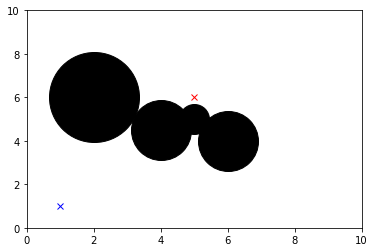

In [21]:
plot_env()

In [50]:
# Graph
G = {
        "nodes" : [start_pt],
        "edges" : dict()
    }

# def get_nearest_node(rand_pt,G,bounds=bounds):
    

# ## RRT!
MAX_ITERS = 10000
goal = False
iters = 0
while not goal and iters < MAX_ITERS:
    
    rand_pt = rand_free_pt();
    
    # Find nearest node
    min_dist = dist((bounds['x'][0], bounds['y'][0]), (bounds['x'][1], bounds['y'][1]))
    for i,node in enumerate(G['nodes']):
        d = dist(rand_pt,node)
        if d < min_dist:
            min_dist = d
            nearest_node_index = i
            nearest_node = node 

    # If rand_pt is more than a delta away from the nearest node, make proxy point 
    # delta away in direction of rand_pt.
    if (min_dist > delta):
        theta = angle(nearest_node,rand_pt)
        rand_pt = [ nearest_node[0] + delta*math.cos(theta),
                    nearest_node[1] + delta*math.sin(theta)]
    # Check if there are any collisions between nearest node and (possibly updated) rand_pt
    if not check_collisions_between(nearest_node,rand_pt):
        G['nodes'].append(rand_pt)
        G['edges'].update({(len(G['nodes'])-1) : int(nearest_node_index)}) # key=child, value=parent -- makes it easy
                                                                        # to search for parent of child    
        # End condition
        goal_unc = 0.3
        if ( dist(rand_pt,goal_pt)<goal_unc ):
            goal = True
    
    iters += 1

if goal:
    print('Goal reached')
else:
    print('No luck')


Goal reached


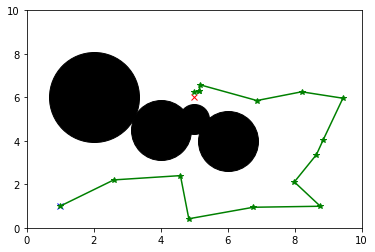

In [51]:
# Backtrack to find correct path

# Find parent of this node
path = [ len(G['nodes'])-1 ]
while( G['nodes'][path[-1]] != start_pt ):
    child = path[-1]
    parent = G['edges'][child]
    path.append(parent)
    
# Plot found path
plot_env()
last_pt = G['nodes'][path[0]]
for ind in path:
    pt = G['nodes'][ind]
    plt.plot([last_pt[0], pt[0]], [last_pt[1], pt[1]], 'g')
    plt.plot(pt[0],pt[1],'*g')
    last_pt = pt